# Panoptic Segmentation demo

A quick demo to test the performance of Mask2Former for panoptic segmentation and show how to use models from Hugging Face.
Inference time is about 1s on an A100/20C grid GPU.

If you want to fine tune or retrain this model, look up guides on Hugging Face for help.

In [1]:
import requests
import torch
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from collections import defaultdict
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/appuser/.local/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/appuser/.local/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:

In [2]:
# load Mask2Former fine-tuned on COCO panoptic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/appuser/.local/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


### Load image and run inference

`label_ids_to_fuse` unset. No instance will be fused.


Preprocessing time: 0.105 seconds
Inference time: 0.975 seconds
Postprocessing time: 1.094 seconds
Total time: 2.175 seconds
FPS: 0.46


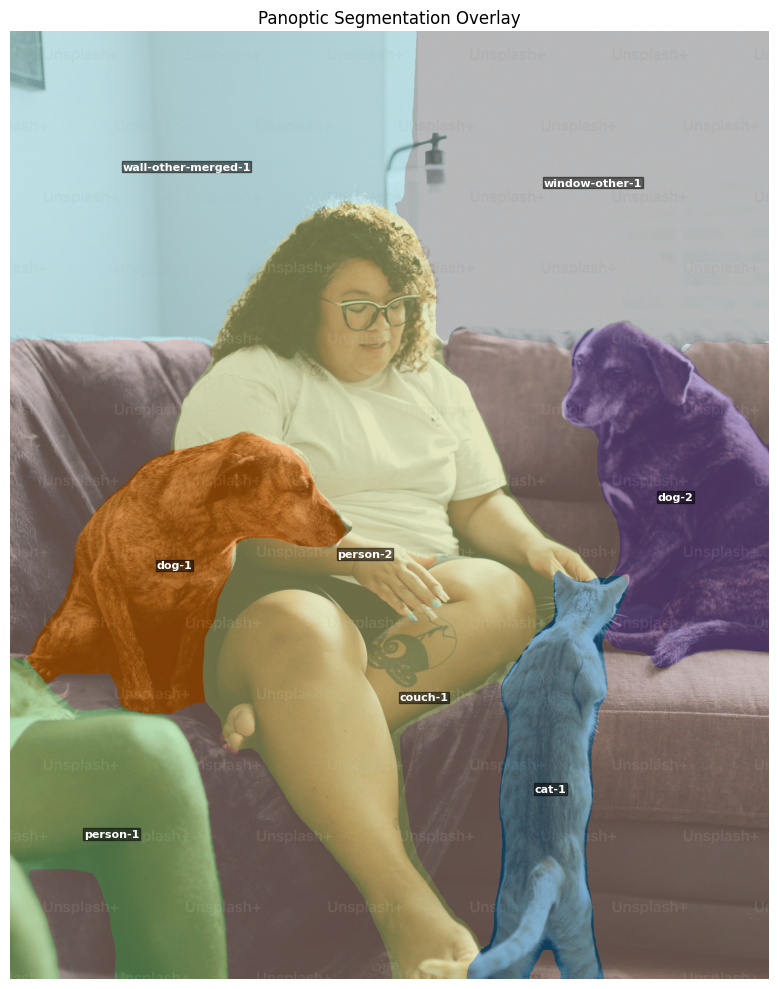

In [7]:
# Choose an image
url = "https://plus.unsplash.com/premium_photo-1664371206092-fd3d00506365?q=80&w=1665&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
# url = "https://assets.telex.hu/images/20250121/1737470434-temp-Ellckj_cover@4x.jpg"
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Measure preprocessing time
preprocess_start = time.time()
inputs = processor(images=image, return_tensors="pt")
preprocess_time = time.time() - preprocess_start

# Measure inference time
inference_start = time.time()
with torch.no_grad():
    outputs = model(**inputs)
inference_time = time.time() - inference_start

# Measure postprocessing time
postprocess_start = time.time()
prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
postprocess_time = time.time() - postprocess_start

print(f"Preprocessing time: {preprocess_time:.3f} seconds")
print(f"Inference time: {inference_time:.3f} seconds")
print(f"Postprocessing time: {postprocess_time:.3f} seconds")
print(f"Total time: {preprocess_time + inference_time + postprocess_time:.3f} seconds")
print(f"FPS: {1.0/(preprocess_time + inference_time + postprocess_time):.2f}")

# Create visualization
plt.figure(figsize=(15, 10))

# Get segmentation and segments info from prediction
segmentation = prediction['segmentation']
segments_info = prediction['segments_info']

# Create a single subplot for overlaid visualization
plt.imshow(image)
plt.axis('off')
plt.title('Panoptic Segmentation Overlay')

# Create colormap with distinct colors for different segments
num_segments = len(segments_info)
colors = plt.cm.tab20(np.linspace(0, 1, num_segments))
colormap = np.zeros((torch.max(segmentation).item() + 1, 4))

# Initialize instance counter
instances_counter = defaultdict(int)

# Assign colors to each segment and create mask overlay
segmentation_np = segmentation.cpu().numpy()
overlay = np.zeros((*segmentation_np.shape, 4))

for idx, segment in enumerate(segments_info):
    segment_id = segment['id']
    segment_label_id = segment['label_id']
    segment_label = model.config.id2label[segment_label_id]
    
    # Increment instance counter for this class
    instances_counter[segment_label] += 1
    instance_label = f"{segment_label}-{instances_counter[segment_label]}"
    
    # Create mask for this segment
    mask = segmentation_np == segment_id
    
    # Assign semi-transparent color
    color = colors[idx].copy()
    color[-1] = 0.5  # Set alpha to 0.5 for transparency
    overlay[mask] = color
    
    # Calculate center of mass for this segment for label placement
    y_coords, x_coords = np.where(mask)
    if len(y_coords) > 0:  # Only if the segment is not empty
        center_y = int(np.mean(y_coords))
        center_x = int(np.mean(x_coords))
        
        # Add label at the center of the segment
        plt.text(center_x, center_y, instance_label,
                color='white', fontsize=8, fontweight='bold',
                bbox=dict(facecolor='black', alpha=0.5, pad=0.5),
                ha='center', va='center')

# Show the overlay
plt.imshow(overlay)
plt.tight_layout()
plt.show()
# plt.savefig('segmentation_result.png', bbox_inches='tight', dpi=300)
# plt.close()
